# GPR
 * Implement log marginal likelihood optimization
 * Implement multiple kernels
     * linear
     * periodic
     * rational quadratic
 * Use HXDY to do log marginal likelihood optimization
#### Imports and Function Defs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.sparse.linalg

### Kernel Defs

In [4]:
#@nb.njit(cache=True)
def rbf(xp, xq, l, sf):
    return sf*sf*np.exp(-.5 * np.power((xp-xq)/l, 2))

In [63]:
def periodic(xp, xq, l, mu, sf):
    return sf*sf*np.exp(np.cos((xp-xq)/l - mu))

### Kernel Derivative Defs

In [5]:
#@nb.njit(cache=True)
def rbf_prime(xp, xq, l, sf):
    x_diff = xp-xq # this is a vector
    result = np.empty(2)
    
    result[0] = sf*sf*np.exp(-.5 * np.power(x_diff/l, 2)) * x_diff * x_diff * np.power(l, -3)
        
    result[1] = 2.*sf*np.exp(-.5 * np.power(x_diff/l, 2))
    
    return result

In [64]:
def periodic_prime(xp, xq, l, mu, sf):
    result = np.empty(3)
    exponent_term = np.exp(np.sum(np.cos((xp-xq)/l - mu)))
    result[0] = sf*sf*exponent_term*(xq-xp)*np.sin(mu-(xp-xq)/l)*np.power(l,-2)
    result[1] = sf*sf*exponent_term*(-1.)*np.sin(mu-(xp-xq)/l)
    result[2] = 2.*sf*exponent_term
    return result

### Covariance Matrix Calculations

In [81]:
#@nb.njit(cache=True)
def K_XX(X, l, mu, sf):
    cov = np.empty((len(X),len(X)))
    for i in range(len(X)):
        for j in range(i+1):
            cov[i,j] = cov[j,i] = periodic(X[i], X[j], l, mu, sf) #rbf(X[i], X[j], l, sf)
    return cov

In [82]:
#@nb.njit(cache=True)
def K_XY(X, Y, l, mu, sf):
    cov = np.empty((len(Y),len(X)))
    for i in range(len(Y)):
        for j in range(len(X)):
            cov[i,j] = periodic(Y[i], X[j], l, mu, sf) #rbf(Y[i], X[j], l, sf)
    return cov

### Prediction Tools

In [67]:
#@nb.njit(cache=True)
def predict(X, X_s, l, mu, sf, k_xx_i_y, y_mean):
    return np.dot(K_XY(X, X_s, l, mu, sf), k_xx_i_y) + y_mean

In [78]:
def fitPredict(X_train, y_train, X_test, l, mu, sf):

    k_xx = K_XX(X_train, l, mu, sf)
    y_mean = np.mean(y_train)
    k_xx_i_y = scipy.sparse.linalg.minres(k_xx, y_train-y_mean)[0] 
    pred = predict(X_train, X_test, l, mu, sf, k_xx_i_y, y_mean)
    
    return pred

### $\theta$ Optimization Tools

In [70]:
#@nb.njit(cache=True)
def log_marginal_likelihood(x, y, l, mu, sf):
    K = K_XX(x, l, mu, sf)
    K_inv = np.linalg.pinv(K)
    
    term1 = -.5*np.log(np.linalg.det(K))
    term2 = -.5*((y.T @ K_inv @ y))
    term3 = -(len(x)/2)*np.log(2.*np.pi)
    return -(term1 + term2 + term3)

In [106]:
def log_marginal_likelihood_prime(x, y, l, mu, sf):
    
    K = K_XX(x, l, mu, sf)
    K_inv = np.linalg.pinv(K)

    alpha = y.T @ K_inv

    kernel_der = np.empty((len(x), len(x), 3))

    for i in range(len(x)):
        for j in range(len(x)):
            kernel_der[i,j] = periodic_prime(x[i], x[j], l, mu, sf) #rbf_prime(x[i], x[j], l, sf)
    
    #print(np.around(kernel_der[:,:,0], 2))
    
    der = np.empty(3)
    
    for i in range(len(der)):
        idx = tuple([slice(None)]*(kernel_der.ndim-1) + [i])
        #print(np.around(kernel_der[idx], 2))
        der[i] = (.5 * alpha @ kernel_der[idx] @ alpha.T)
        der[i] -= .5*np.trace(K_inv @ kernel_der[idx])
        #print((.5 * alpha @ kernel_der[idx] @ alpha.T)[0,0], -.5*np.trace(K_inv @ kernel_der[idx]))
    return -der

### Testing

In [72]:
x = np.arange(-np.pi, np.pi, 1e-2)
y = (np.sin(x)**2)

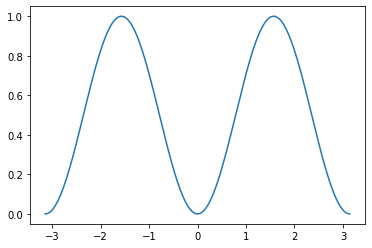

In [73]:
plt.plot(x, y);

In [74]:
l = .1
mu = .5
sf = 1.

In [83]:
p = fitPredict(x[::100], y[::100], x, l, mu, sf)

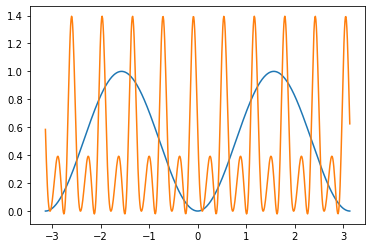

In [84]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');

In [91]:
l = 1.
mu = .5
sf = 1.

In [92]:
p = fitPredict(x[::100], y[::100], x, l, mu, sf)

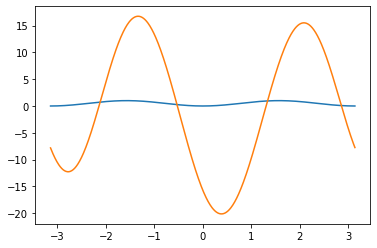

In [93]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');

In [23]:
l_range = np.arange(.1, 2, 1e-2)

In [24]:
sf = 1.

In [25]:
z = np.empty((len(l_range), 2))

In [30]:
for i in range(len(l_range)):
    z[i, 0] = log_marginal_likelihood_prime(x[::100], y[::100], l_range[i], sf)[0]
    z[i, 1] = log_marginal_likelihood(x[::100], y[::100], l_range[i], sf)

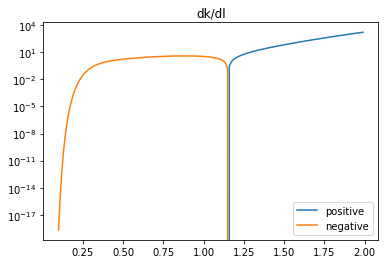

In [31]:
plt.plot(l_range, z[:,0], label='positive')
plt.plot(l_range, -z[:,0], label='negative')
plt.legend()
plt.title('dk/dl')
plt.yscale('log');

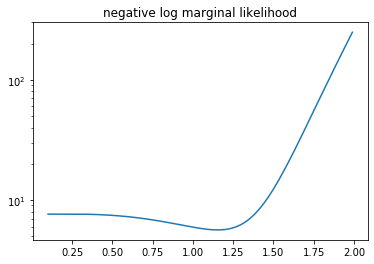

In [32]:
plt.plot(l_range, z[:,1])
plt.title('negative log marginal likelihood')
plt.yscale('log');

In [33]:
sf_range = np.arange(.1, 2, 1e-2)

In [36]:
l = 1.24

In [37]:
z = np.empty((len(sf_range), 2))

In [38]:
for i in range(len(l_range)):
    z[i, 0] = log_marginal_likelihood_prime(x[::100], y[::100], l, sf_range[i])[1]
    z[i, 1] = log_marginal_likelihood(x[::100], y[::100], l, sf_range[i])

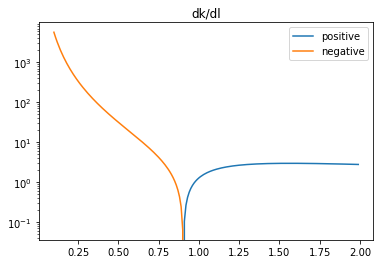

In [39]:
plt.plot(l_range, z[:,0], label='positive')
plt.plot(l_range, -z[:,0], label='negative')
plt.legend()
plt.title('dk/dl')
plt.yscale('log');

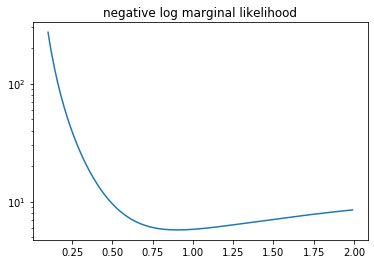

In [40]:
plt.plot(l_range, z[:,1])
plt.title('negative log marginal likelihood')
plt.yscale('log');

In [41]:
l = 1.24*np.ones(1)
sf = .75

In [42]:
p = fitPredict(x[::100], y[::100], x, l, sf)

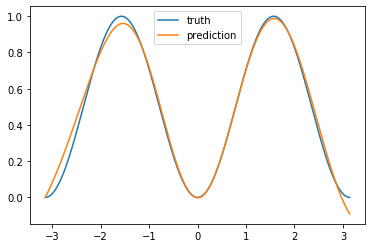

In [129]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');
plt.legend();

In [94]:
import scipy.optimize

In [97]:
def func_wrapper(params, x, y):
    l = params[0]
    mu = params[1]
    sf = params[2]
    return log_marginal_likelihood(x, y, l, mu, sf), log_marginal_likelihood_prime(x, y, l, mu, sf)

In [134]:
best = scipy.optimize.minimize(func_wrapper, x0=(1, 1, 1), args=(x[::100], y[::100]), jac=True, method='BFGS')
best

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


      fun: -5.288313495453599
 hess_inv: array([[1.37667427, 0.70809979, 2.87869083],
       [0.70809979, 1.34480908, 1.3488662 ],
       [2.87869083, 1.3488662 , 6.26570138]])
      jac: array([-5.6055008 ,  1.37171332,  6.21540776])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 17
      nit: 1
     njev: 11
   status: 2
  success: False
        x: array([0.28991493, 0.81417837, 0.30620644])

In [123]:
l = best.x[0]
mu = best.x[1]
sf = best.x[2]

In [124]:
l, mu,  sf

(-1.1565185953293526, 0.00036525885912774836, -1.263838373714636)

In [127]:
p = fitPredict(x[::100], y[::100], x, l, mu, sf)

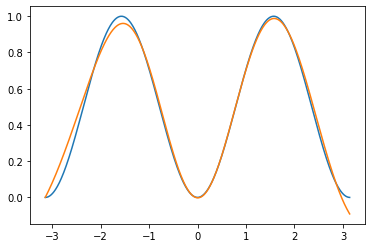

In [128]:
plt.plot(x, y, label='truth')
plt.plot(x, p, label='prediction');

In [57]:
l_range = np.arange(.3, 5, 1e-2)
sf_range = np.arange(.3, 5, 1e-2)

In [58]:
z = np.empty((len(l_range), len(sf_range)))
for i in range(len(l_range)):
    for j in range(len(sf_range)):
        z[i,j] = log_marginal_likelihood(x[::100], y[::100], l_range[i], sf_range[j])

In [59]:
from matplotlib.colors import LogNorm

In [60]:
z.shape

(470, 470)

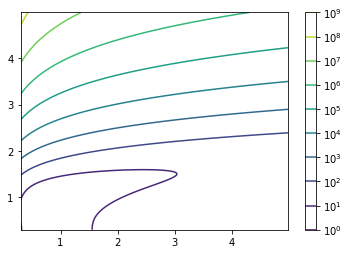

In [61]:
plt.contour(l_range, sf_range, z, levels=100, norm=LogNorm())
plt.colorbar()